## setup

In [11]:
import torch
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
from models.decoder import Decoder
from models.flow_decoder import FlowDecoder
from models.encoder import Encoder
from utils.load_data import load_dataset
from config import DATA_PATH
import tensorflow as tf
from utils.fNN_layers import *
from utils.load_data import extract_target_properties
from utils.mathops import dyad
from functools import partial
from itertools import permutations, product

# === set seed for reproducibility ===
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed_all(SEED)  # optional: if using CUDA

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# === setup device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# === specify trial number ===
trial = 11

# === load paths ===
trial_dir = f"checkpoints/trial_{trial}"
decoder_path = os.path.join(trial_dir, f"decoder_ckpt_{trial}.pt")
encoder_path = os.path.join(trial_dir, f"encoder_ckpt_{trial}.pt")
config_path = os.path.join(trial_dir, f"config_{trial}.txt")

# === load config from file ===
with open(config_path, "r") as f:
    lines = f.readlines()
config_dict = {line.split(":")[0].strip(): eval(line.split(":")[1].strip()) for line in lines}

# === extract config values ===
S_DIM = config_dict["S_DIM"]
P_DIM = config_dict["P_DIM"]
LATENT_DIM = config_dict["LATENT_DIM"]
DECODER_HIDDEN_DIMS = config_dict["DECODER_HIDDEN_DIMS"]
ENCODER_HIDDEN_DIMS = config_dict["ENCODER_HIDDEN_DIMS"]
NUM_FLOWS = config_dict["NUM_FLOWS"]  

# === initialize decoder ===
# decoder = Decoder(S_DIM, P_DIM, LATENT_DIM, DECODER_HIDDEN_DIMS).to(device)
decoder = FlowDecoder(S_DIM, P_DIM, LATENT_DIM, DECODER_HIDDEN_DIMS, NUM_FLOWS).to(device)
decoder.load_state_dict(torch.load(decoder_path, map_location=device))
decoder.eval()
print("✅ Loaded decoder from trial", trial)

# === initialize encoder (for latent space visualization) ===
encoder = Encoder(S_DIM, P_DIM, LATENT_DIM, ENCODER_HIDDEN_DIMS).to(device)
encoder.load_state_dict(torch.load(encoder_path, map_location=device))
print("✅ Loaded encoder from trial", trial)

# === print config ===
print("✅ Config for trial", trial)
for k, v in config_dict.items():
    print(f"   - {k}: {v}")

✅ Loaded decoder from trial 11
✅ Loaded encoder from trial 11
✅ Config for trial 11
   - S_DIM: 4
   - P_DIM: 9
   - LATENT_DIM: 4
   - ENCODER_HIDDEN_DIMS: [128, 64, 32]
   - DECODER_HIDDEN_DIMS: [128, 64, 32]
   - BATCH_SIZE: 64
   - LEARNING_RATE: 0.001
   - NUM_EPOCHS: 100
   - BETA: 0.0
   - NUM_FLOWS: 4


/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_69191/876144641.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load(decoder_pa

## functions for sampling s-hat predictions (1000) and extract peaks using meanshift

In [13]:
# === sampling function ===
def get_S_hats(P_val, num_samples=1000):
    P_tensor = P_val.repeat(num_samples, 1).to(device)
    z_samples = torch.randn((num_samples, LATENT_DIM)).to(device)
    with torch.no_grad():
        S_hats = decoder(z_samples, P_tensor)
    return S_hats.cpu().numpy()

# === peak extraction ===
def get_S_hat_peaks(S_hats, bandwidth=5.0):
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(S_hats)
    return ms.cluster_centers_

## load in data, sample, extract peaks, run bandwith sanity check

In [16]:
# === load data ===
P_all, S_all = load_dataset(DATA_PATH)
P_val = P_all[0].unsqueeze(0).to(device)   # (1, P_dim)
S_true = S_all[0].cpu().numpy()            # (S_dim,)

# === run sampling and peak extraction ===
S_hats, _ = get_S_hats(P_val, num_samples=1000)
S_hat_peaks, _ = get_S_hat_peaks(S_hats, bandwidth=20.0) # choose 20.0 for consistency but see other options below

# === print number of peaks for different bandwidths ===
print("\nBandwidth sensitivity:")
for bw in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]:
    peaks = get_S_hat_peaks(S_hats, bandwidth=bw)
    print(f"Bandwidth {bw:.1f}: Found {len(peaks)} peak(s)")

AttributeError: 'tuple' object has no attribute 'cpu'

## visualize encoder latent space

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_66422/1998319648.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Z_2D[:, 0], Z_2D[:, 1], alpha=0.6, s=20, cmap='viridis')


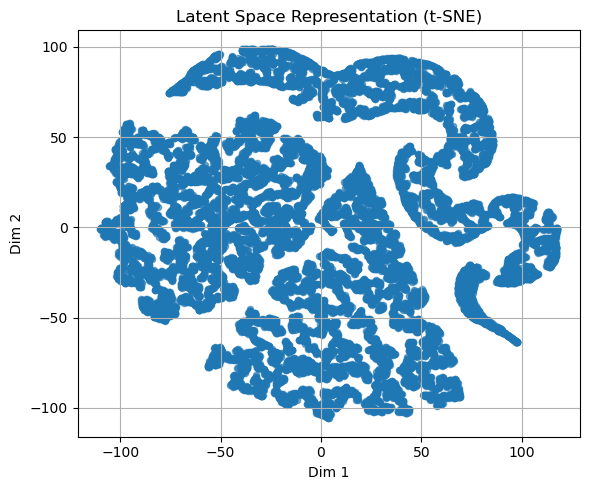

In [ ]:
from sklearn.manifold import TSNE

# === compute latent representations (mean vectors only) ===
with torch.no_grad():
    mu_list = []
    for i in range(len(P_all)):
        S_i = S_all[i].unsqueeze(0).to(device)
        P_i = P_all[i].unsqueeze(0).to(device)
        mu, _ = encoder(S_i, P_i)
        mu_list.append(mu.cpu().numpy())

Z_mu = np.vstack(mu_list)  # shape: (num_samples, latent_dim)

# === dimensionality reduction ===
# option 1: PCA
# pca = PCA(n_components=2)
# Z_2D = pca.fit_transform(Z_mu)

# option 2: t-SNE (uncomment if preferred)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=SEED)
Z_2D = tsne.fit_transform(Z_mu)

# === visualization ===
plt.figure(figsize=(6, 5))
plt.scatter(Z_2D[:, 0], Z_2D[:, 1], alpha=0.6, s=20, cmap='viridis')
plt.title("Latent Space Representation (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()


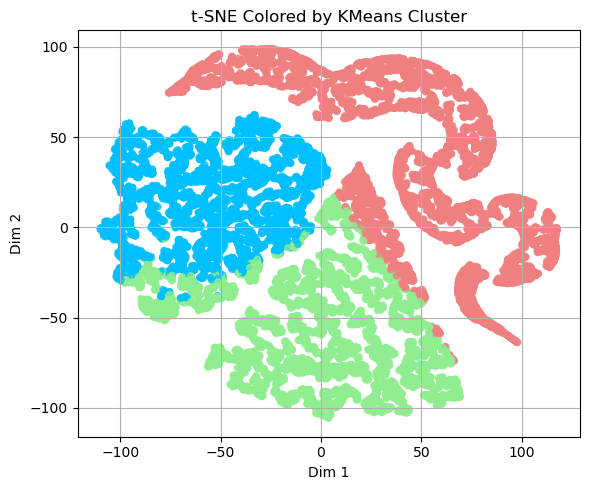

In [ ]:
from sklearn.cluster import KMeans

# === cluster latent vectors ===
n_clusters = 3  # adjust this if needed
kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
cluster_labels = kmeans.fit_predict(Z_mu)


# define a list of RGB or named colors
cluster_colors = ['deepskyblue', 'lightcoral', 'lightgreen']  # One for each cluster

# map each point’s cluster label to its color
colors = [cluster_colors[label] for label in cluster_labels]

# plot with custom colors
plt.figure(figsize=(6, 5))
plt.scatter(Z_2D[:, 0], Z_2D[:, 1], c=colors, s=20, alpha=0.7)
plt.title("t-SNE Colored by KMeans Cluster")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# === RED CLUSTER === (2 zeroes)
# define bounds for the region (tweak these numbers based on your plot)
x_min, x_max = 50, 100   # Dim 1
y_min, y_max = 0, 50    # Dim 2
# get indices that fall inside this region *and* belong to a specific cluster
target_cluster = 1

# # === GREEN CLUSTER === (1 zero)
# x_min, x_max = 0, 50
# y_min, y_max = -100, -50
# target_cluster = 2

# # === BLUE CLUSTER === (0 zeroes)
# x_min, x_max = -100, -50
# y_min, y_max = 0, 50
# target_cluster = 0

region_mask = (
    (Z_2D[:, 0] >= x_min) & (Z_2D[:, 0] <= x_max) &
    (Z_2D[:, 1] >= y_min) & (Z_2D[:, 1] <= y_max) &
    (cluster_labels == target_cluster)
)
region_indices = np.where(region_mask)[0]

for idx in region_indices[:5]:  # limit to first 10
    print(f"S[{idx}] = {S_all[idx].numpy()}")
    print(f"P[{idx}] = {P_all[idx].numpy()}")

S[14002] = [66.83771     0.          0.          0.72978556]
P[14002] = [0.5251746  0.21856147 0.21872914 0.67915165 0.24018121 0.68224245
 0.4341425  0.3912983  0.39090028]
S[14009] = [73.79295     0.          0.          0.93319726]
P[14009] = [1.118125   0.46380246 0.46324742 1.1542768  0.47095194 1.1525631
 0.67932165 0.66931206 0.6701803 ]
S[14029] = [70.53102   0.        0.        0.935203]
P[14029] = [1.1207806  0.4659289  0.4657529  1.1600871  0.47418046 1.1597891
 0.6826623  0.6718768  0.67210376]
S[14035] = [73.377785   0.         0.         0.8179083]
P[14035] = [0.77806044 0.31051317 0.30988833 0.8571277  0.32314232 0.86079115
 0.53108084 0.5091416  0.5105522 ]
S[14038] = [73.051476    0.          0.          0.64155406]
P[14038] = [0.38118538 0.15560815 0.1560672  0.49704686 0.16849777 0.5084291
 0.32884443 0.29731572 0.2945823 ]


## visualize decoder output space $\hat{S} \sim p(\mathcal{S} \mid \mathcal{P})$ using pca projection

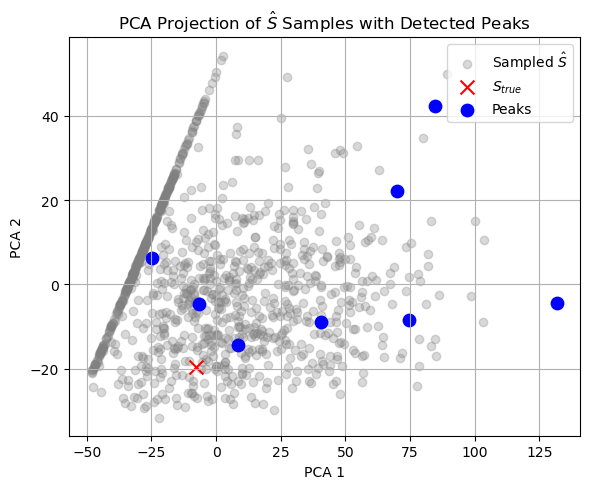

In [ ]:
# === pca projection of S_hats, S_true, and peaks ===
pca = PCA(n_components=2)
S_pca = pca.fit_transform(S_hats)
S_true_pca = pca.transform(S_true.reshape(1, -1))
S_peaks_pca = pca.transform(S_hat_peaks)

plt.figure(figsize=(6, 5))
plt.scatter(S_pca[:, 0], S_pca[:, 1], alpha=0.3, label=r"Sampled $\hat{S}$", color='gray')
plt.scatter(S_true_pca[0, 0], S_true_pca[0, 1], color='red', marker='x', s=100, label=r"$S_{true}$")
plt.scatter(S_peaks_pca[:, 0], S_peaks_pca[:, 1], color='blue', marker='o', s=80, label="Peaks")
plt.title(r"PCA Projection of $\hat{S}$ Samples with Detected Peaks")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## load fNN model for evaluation

In [ ]:
# === load max's fNN model ===
custom_objects = {
    'PermutationEquivariantLayer': PermutationEquivariantLayer,
    'DoubleContractionLayer': DoubleContractionLayer,
    'EnforceIsotropyLayer': EnforceIsotropyLayer,
    'NormalizationLayer': NormalizationLayer
}

fNN = tf.keras.models.load_model('utils/max_fNN.h5', custom_objects=custom_objects)  # adjust path if needed
print("✅ Loaded Max's forward model")

# === evaluate each S_hat_peak ===
P_target = P_val.cpu().numpy().flatten()  # shape: (9,)

for i, S_peak in enumerate(S_hat_peaks):
    S_peak_tf = np.expand_dims(S_peak, axis=(0, 1))  # shape: (1, 1, 4)
    # output: shape (1, 1, 3, 3, 3, 3)
    C_pred = fNN(S_peak_tf).numpy()

    # reshape to (1, 3, 3, 3, 3)
    C_pred = C_pred.reshape(1, 3, 3, 3, 3)

    # extract 9 elastic constants → shape (1, 9)
    P_pred = extract_target_properties(C_pred)[0]  # remove batch dim

    error = np.linalg.norm(P_pred - P_target)
    # print(f"Peak {i}: ||P_pred - P_true|| = {error:.4f}")
    # print("  P_pred:", P_pred.round(3))
    # print("  P_true:", P_target.round(3))

✅ Loaded Max's forward model


In [ ]:
def plot_all_P_preds_vs_true(P_preds, P_true):
    """
    Plots all P_pred vs P_true bar plots in a grid layout.

    Args:
        P_preds (list of np.ndarray): List of predicted property vectors (each shape (9,))
        P_true (np.ndarray): Ground-truth property vector (shape (9,))
    """
    labels = [
        "C1111", "C1122", "C1133", "C2222", "C2233", "C3333",
        "C1212", "C1313", "C2323"
    ]
    num_peaks = len(P_preds)
    cols = 3
    rows = (num_peaks + cols - 1) // cols  # ceiling division
    width = 0.35
    x = np.arange(len(labels))

    fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
    axs = axs.flatten()

    for i in range(num_peaks):
        ax = axs[i]
        ax.bar(x - width/2, P_true, width, label='True P', color='lightcoral')
        ax.bar(x + width/2, P_preds[i], width, label='Predicted P', color='skyblue')
        ax.set_title(f"Peak {i + 1}")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45)
        ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    for j in range(num_peaks, len(axs)):
        axs[j].axis('off')  # hide unused subplots

    axs[0].legend(loc='upper right')
    fig.suptitle("Elastic Components: Predicted vs True for All Peaks", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Peak   ||P_pred - P_true||    MSE (per peak) 
---------------------------------------------
0      0.3774                 0.0158         
1      0.3383                 0.0127         
2      0.3362                 0.0126         
3      0.3430                 0.0131         
4      0.3605                 0.0144         
5      0.3969                 0.0175         
6      0.3595                 0.0144         
7      0.3639                 0.0147         

✅ Mean MSE across all peaks: 0.0144

✅ Loaded decoder from trial 4
S_DIM: 4
P_DIM: 9
LATENT_DIM: 4
ENCODER_HIDDEN_DIMS: [128, 64, 32]
DECODER_HIDDEN_DIMS: [128, 64, 32]
BATCH_SIZE: 64
LEARNING_RATE: 0.001
NUM_EPOCHS: 100
BETA: 0.5


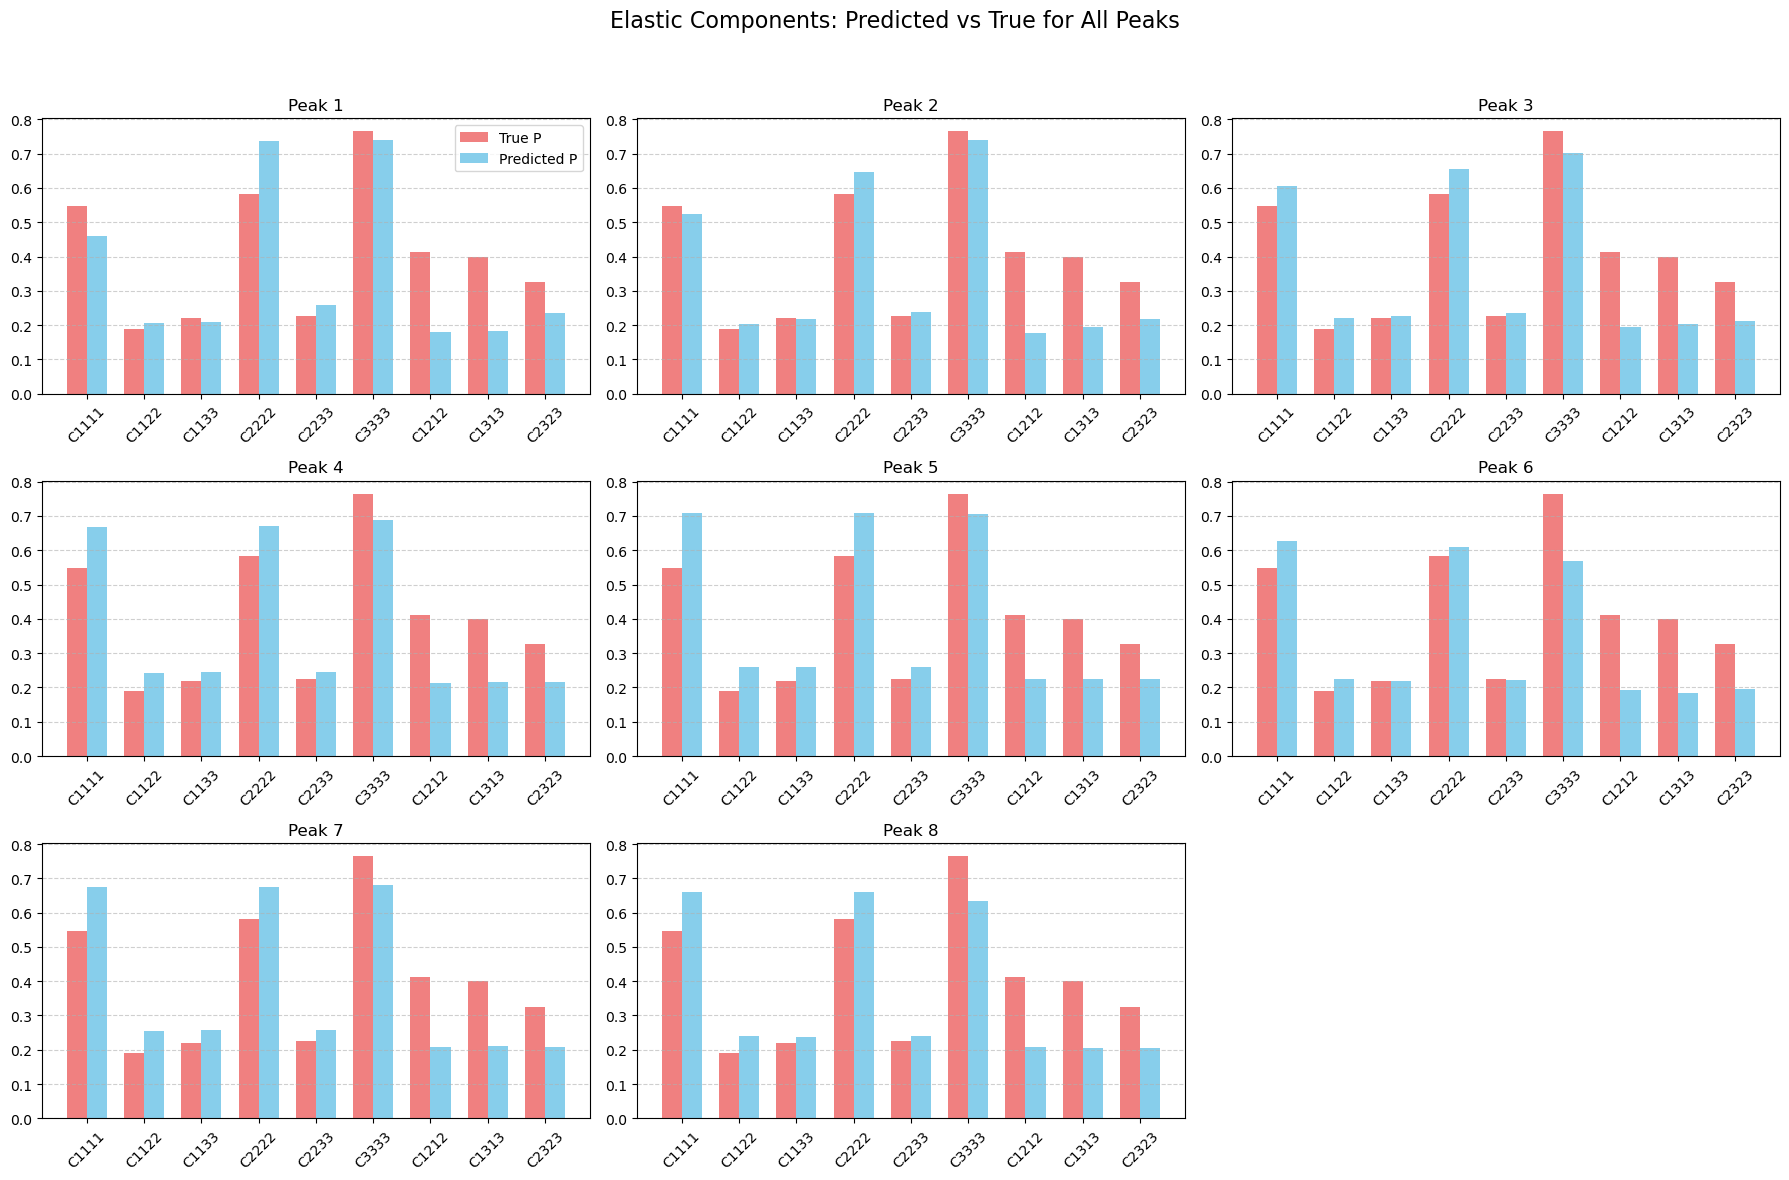

In [ ]:
# === evaluate each S_hat_peak ===
P_preds = []
errors = []
mses = []

print(f"{'Peak':<6} {'||P_pred - P_true||':<22} {'MSE (per peak)':<15}")
print("-" * 45)

for i, S_peak in enumerate(S_hat_peaks):
    S_peak_tf = np.expand_dims(S_peak, axis=(0, 1))  # shape: (1, 1, 4)
    C_pred = fNN(S_peak_tf).numpy().reshape(1, 3, 3, 3, 3)
    P_pred = extract_target_properties(C_pred)[0]  # shape: (9,)
    P_preds.append(P_pred)

    # compute metrics
    l2_error = np.linalg.norm(P_pred - P_target)
    mse = np.mean((P_pred - P_target) ** 2)
    errors.append(l2_error)
    mses.append(mse)

    # print row
    print(f"{i:<6} {l2_error:<22.4f} {mse:<15.4f}")

# === summary ===
mean_mse = np.mean(mses)
print(f"\n✅ Mean MSE across all peaks: {mean_mse:.4f}")
print("\n✅ Loaded decoder from trial", trial)
for k, v in config_dict.items():
    print(f"{k}: {v}")

# === plot predicted vs true ===
plot_all_P_preds_vs_true(P_preds, P_target)


In [ ]:
closest_idx = np.argmin(np.linalg.norm(S_hats - S_true, axis=1))
closest_dist = np.linalg.norm(S_hats[closest_idx] - S_true)

print(f"Closest sampled S_hat is at index {closest_idx} with distance {closest_dist:.4f}")

Closest sampled S_hat is at index 792 with distance 3.4468
